In [1]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

/tmp/ipykernel_965432/2499221329.py:1: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  import nistats
/home/scotti/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


### quickly show what kernel glms are done on


In [2]:
smoothed = sorted(glob.glob('/home/scotti/projects/3t_7t_sst_comparison/derivatives/susan_smoothed_hp_func/*/sub-*/func/sub-*_run-1_space-T1w_desc-preproc_bold_smoothed_fwhm-*_tempfilt.nii.gz'))
glms = sorted(glob.glob('/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/group_level_model/*/model-0/model-0/model-0_fwhm-*_subjectlevelcontrast-0_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'))
slms = sorted(glob.glob('/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/*/sub-*/func/fwhm-*'))

In [3]:
# what fwhm group glms are run?
[(x.split('/')[8],x.split('fwhm-')[-1].split('_')[0]) for x in glms if 'base' not in x]

[('Leipzig_7T_GdH', '1p5'),
 ('Leipzig_7T_GdH', '3p125'),
 ('Leipzig_7T_GdH', '5p0'),
 ('Leipzig_7T_SM', '1p6'),
 ('Leipzig_7T_SM', '3p125'),
 ('Leipzig_7T_SM', '5p0'),
 ('NTNU_7T_SJSI', '1p5'),
 ('NTNU_7T_SJSI', '3p125'),
 ('NTNU_7T_SJSI', '5p0'),
 ('aron_3T', '3p125'),
 ('aron_3T', '5p0'),
 ('openfmri_3T', '3p0'),
 ('openfmri_3T', '3p125'),
 ('openfmri_3T', '5p0')]

In [4]:
# set([(x.split('/')[7],x.split('fwhm-')[-1].split('_')[0]) for x in smoothed])

In [5]:
# set([(x.split('/')[8],x.split('fwhm-')[-1]) for x in slms])

# functions

In [6]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1'):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5
                             }

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

## setup

In [17]:
# BASE LEVEL FWHM
base_gdh = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_GdH'
base_sm = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_SM'
base_sjsi = f'../derivatives/glm_feat_hp_sct/group_level_model/NTNU_7T_SJSI'
base_poldrack = f'../derivatives/glm_feat_hp_sct/group_level_model/openfmri_3T'
base_aron = f'../derivatives/glm_feat_hp_sct/group_level_model/aron_3T'
base_sebastian = f'../derivatives/glm_feat_hp_sct/group_level_model/sebastian_3T'

fwhm_gdh = '1p5'
fwhm_sm = '1p6'
fwhm_sjsi = '1p5'
fwhm_poldrack = '3p0'
fwhm_aron = '3p125'
fwhm_sebastian = '3p0'

In [24]:
# FWHM EQUAL TO LARGEST VOXEL SIZE
base_gdh = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_GdH'
base_sm = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_SM'
base_sjsi = f'../derivatives/glm_feat_hp_sct/group_level_model/NTNU_7T_SJSI'
base_poldrack = f'../derivatives/glm_feat_hp_sct/group_level_model/openfmri_3T'
base_aron = f'../derivatives/glm_feat_hp_sct/group_level_model/aron_3T'
base_sebastian = f'../derivatives/glm_feat_hp_sct/group_level_model/sebastian_3T'

fwhm_gdh = '3p125'
fwhm_sm = '3p125'
fwhm_sjsi = '3p125'
fwhm_poldrack = '3p125'
fwhm_aron = '3p125'
fwhm_sebastian = '3p0'

In [7]:
# COMMONLY USED FWHM FROM 3T STUDIES
base_gdh = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_GdH'
base_sm = f'../derivatives/glm_feat_hp_sct/group_level_model/Leipzig_7T_SM'
base_sjsi = f'../derivatives/glm_feat_hp_sct/group_level_model/NTNU_7T_SJSI'
base_poldrack = f'../derivatives/glm_feat_hp_sct/group_level_model/openfmri_3T'
base_aron = f'../derivatives/glm_feat_hp_sct/group_level_model/aron_3T'
base_sebastian = f'../derivatives/glm_feat_hp_sct/group_level_model/sebastian_3T'

fwhm_gdh = '5p0'
fwhm_sm = '5p0'
fwhm_sjsi = '5p0'
fwhm_poldrack = '5p0'
fwhm_aron = '5p0'
fwhm_sebastian = '3p0'

In [25]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

# FS - GO
fsgo_gdh, fsgo_thresh_gdh = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_gdh, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_gdh, flame='12')
fsgo_sm, fsgo_thresh_sm = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_sm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sm, flame='12')
fsgo_sjsi, fsgo_thresh_sjsi = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_sjsi, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sjsi, flame='12')
fsgo_poldrack, fsgo_thresh_poldrack = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_poldrack, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_poldrack, flame='12')
fsgo_aron, fsgo_thresh_aron = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_aron, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_aron, flame='12')
# fsgo_sebastian, fsgo_thresh_sebastian = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm_sebastian, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sebastian, flame='12')

# FS - SS
fsss_gdh, fsss_thresh_gdh = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_gdh, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_gdh, flame='12')
fsss_sm, fsss_thresh_sm = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_sm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sm, flame='12')
fsss_sjsi, fsss_thresh_sjsi = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_sjsi, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sjsi, flame='12')
fsss_poldrack, fsss_thresh_poldrack = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_poldrack, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_poldrack, flame='12')
fsss_aron, fsss_thresh_aron = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_aron, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_aron, flame='12')
# fsss_sebastian, fsss_thresh_sebastian = get_second_level_zmap('fs-ss', 'intercept', fwhm=fwhm_sebastian, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sebastian, flame='12')

# SS - GO
ssgo_gdh, ssgo_thresh_gdh = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_gdh, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_gdh, flame='12')
ssgo_sm, ssgo_thresh_sm = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_sm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sm, flame='12')
ssgo_sjsi, ssgo_thresh_sjsi = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_sjsi, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sjsi, flame='12')
ssgo_poldrack, ssgo_thresh_poldrack = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_poldrack, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_poldrack, flame='12')
ssgo_aron, ssgo_thresh_aron = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_aron, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_aron, flame='12')
# ssgo_sebastian, ssgo_thresh_sebastian = get_second_level_zmap('ss-go', 'intercept', fwhm=fwhm_sebastian, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_sebastian, flame='12')

# COMBINE
zmaps_fsgo = [fsgo_gdh, fsgo_sm, fsgo_sjsi, fsgo_poldrack, fsgo_aron]
thresh_fsgo = [fsgo_thresh_gdh,fsgo_thresh_sm,fsgo_thresh_sjsi,fsgo_thresh_poldrack,fsgo_thresh_aron]

zmaps_fsss = [fsss_gdh, fsss_sm, fsss_sjsi, fsss_poldrack, fsss_aron]
thresh_fsss = [fsss_thresh_gdh,fsss_thresh_sm,fsss_thresh_sjsi,fsss_thresh_poldrack,fsss_thresh_aron]

zmaps_ssgo = [ssgo_gdh, ssgo_sm, ssgo_sjsi, ssgo_poldrack, ssgo_aron]
thresh_ssgo = [ssgo_thresh_gdh,ssgo_thresh_sm,ssgo_thresh_sjsi,ssgo_thresh_poldrack,ssgo_thresh_aron]

/tmp/ipykernel_965432/1219882618.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


# PLOT

## FWHM -> base

## FS - GO

Text(0.5, 1.0, 'z-value')

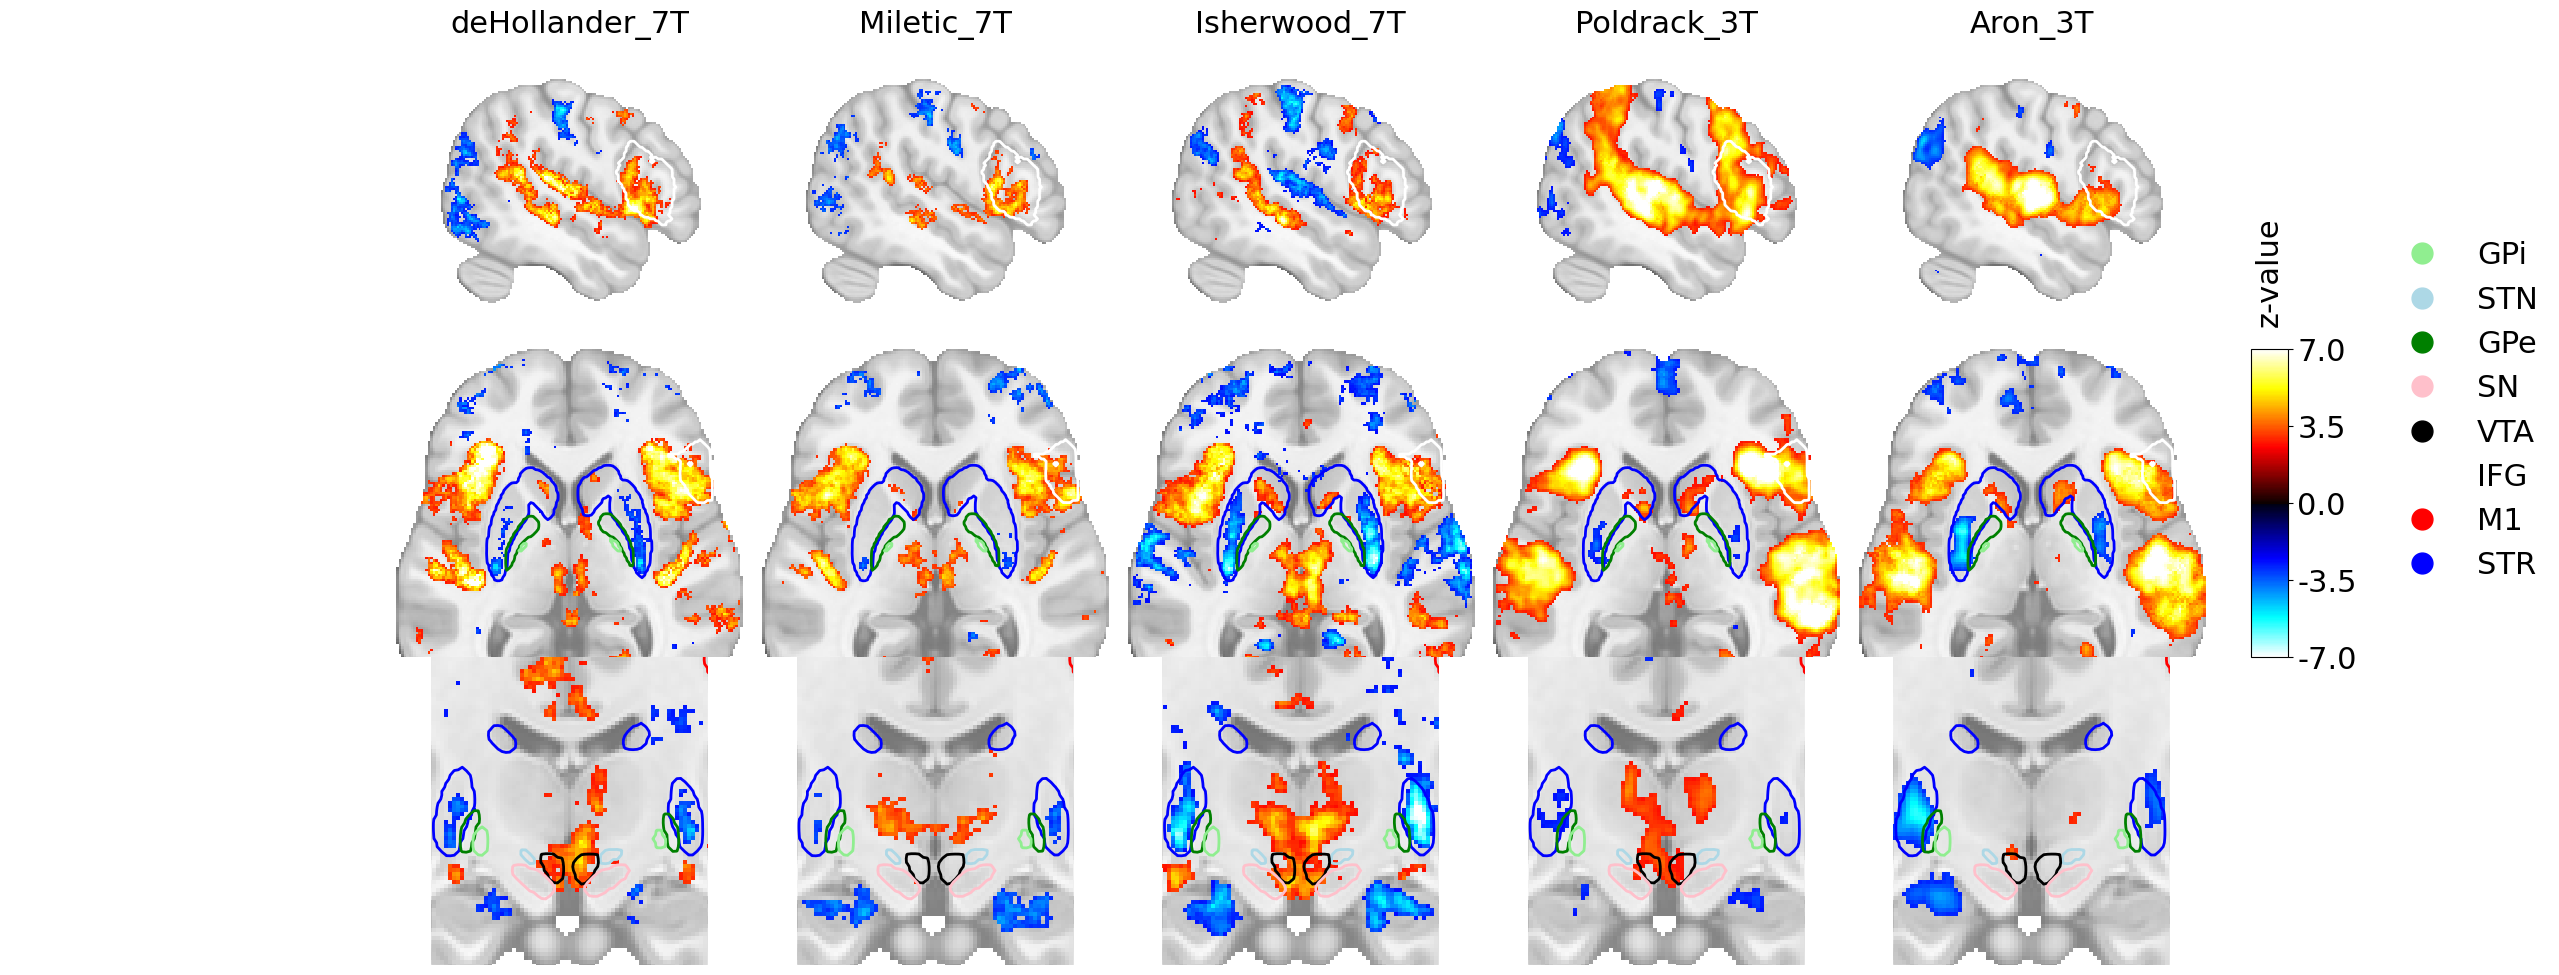

In [19]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FS - SS

Text(0.5, 1.0, 'z-value')

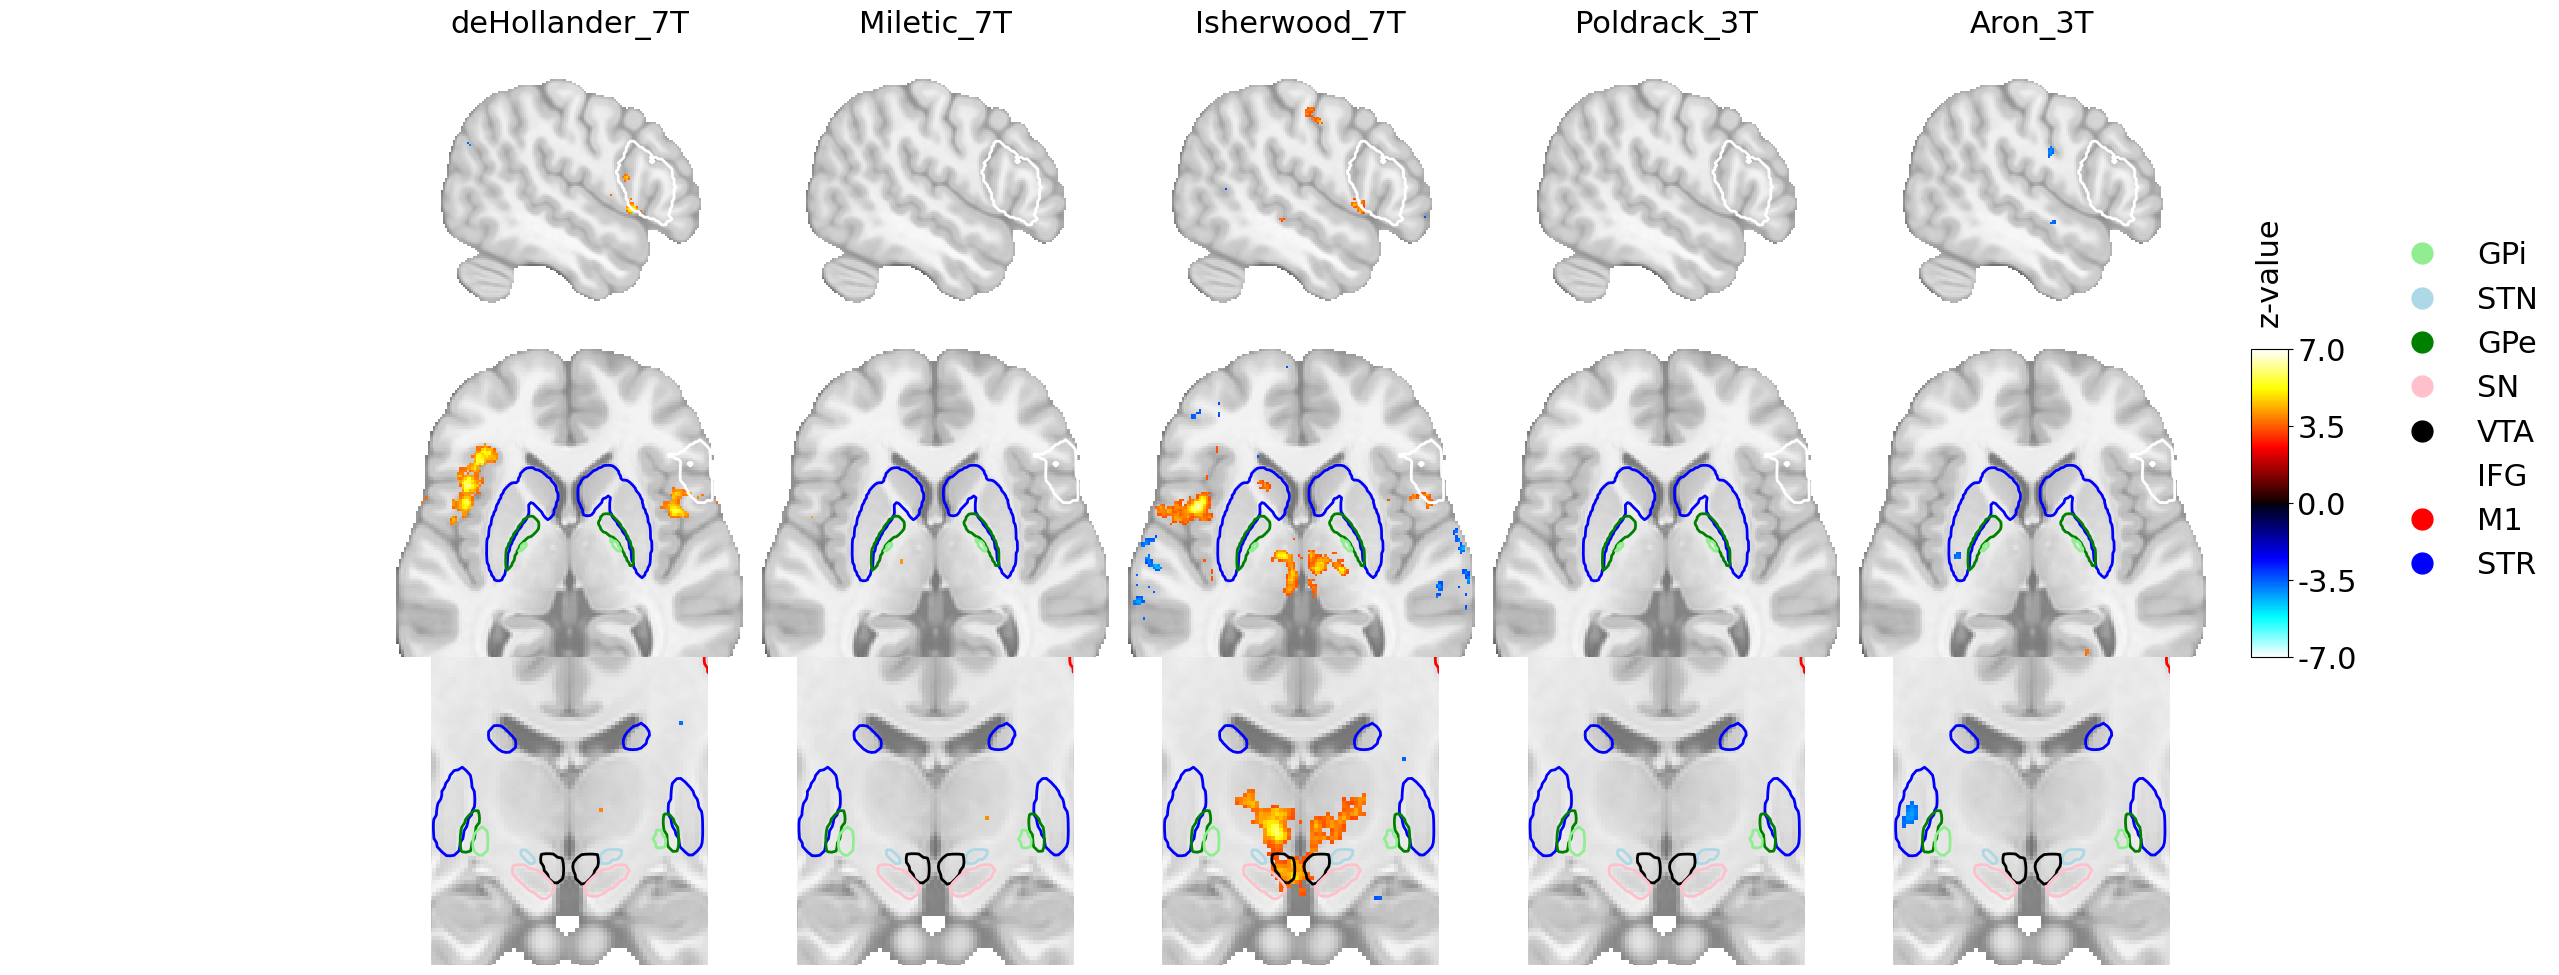

In [20]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsss) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsss)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsss)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsss, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsss,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## SS - GO

Text(0.5, 1.0, 'z-value')

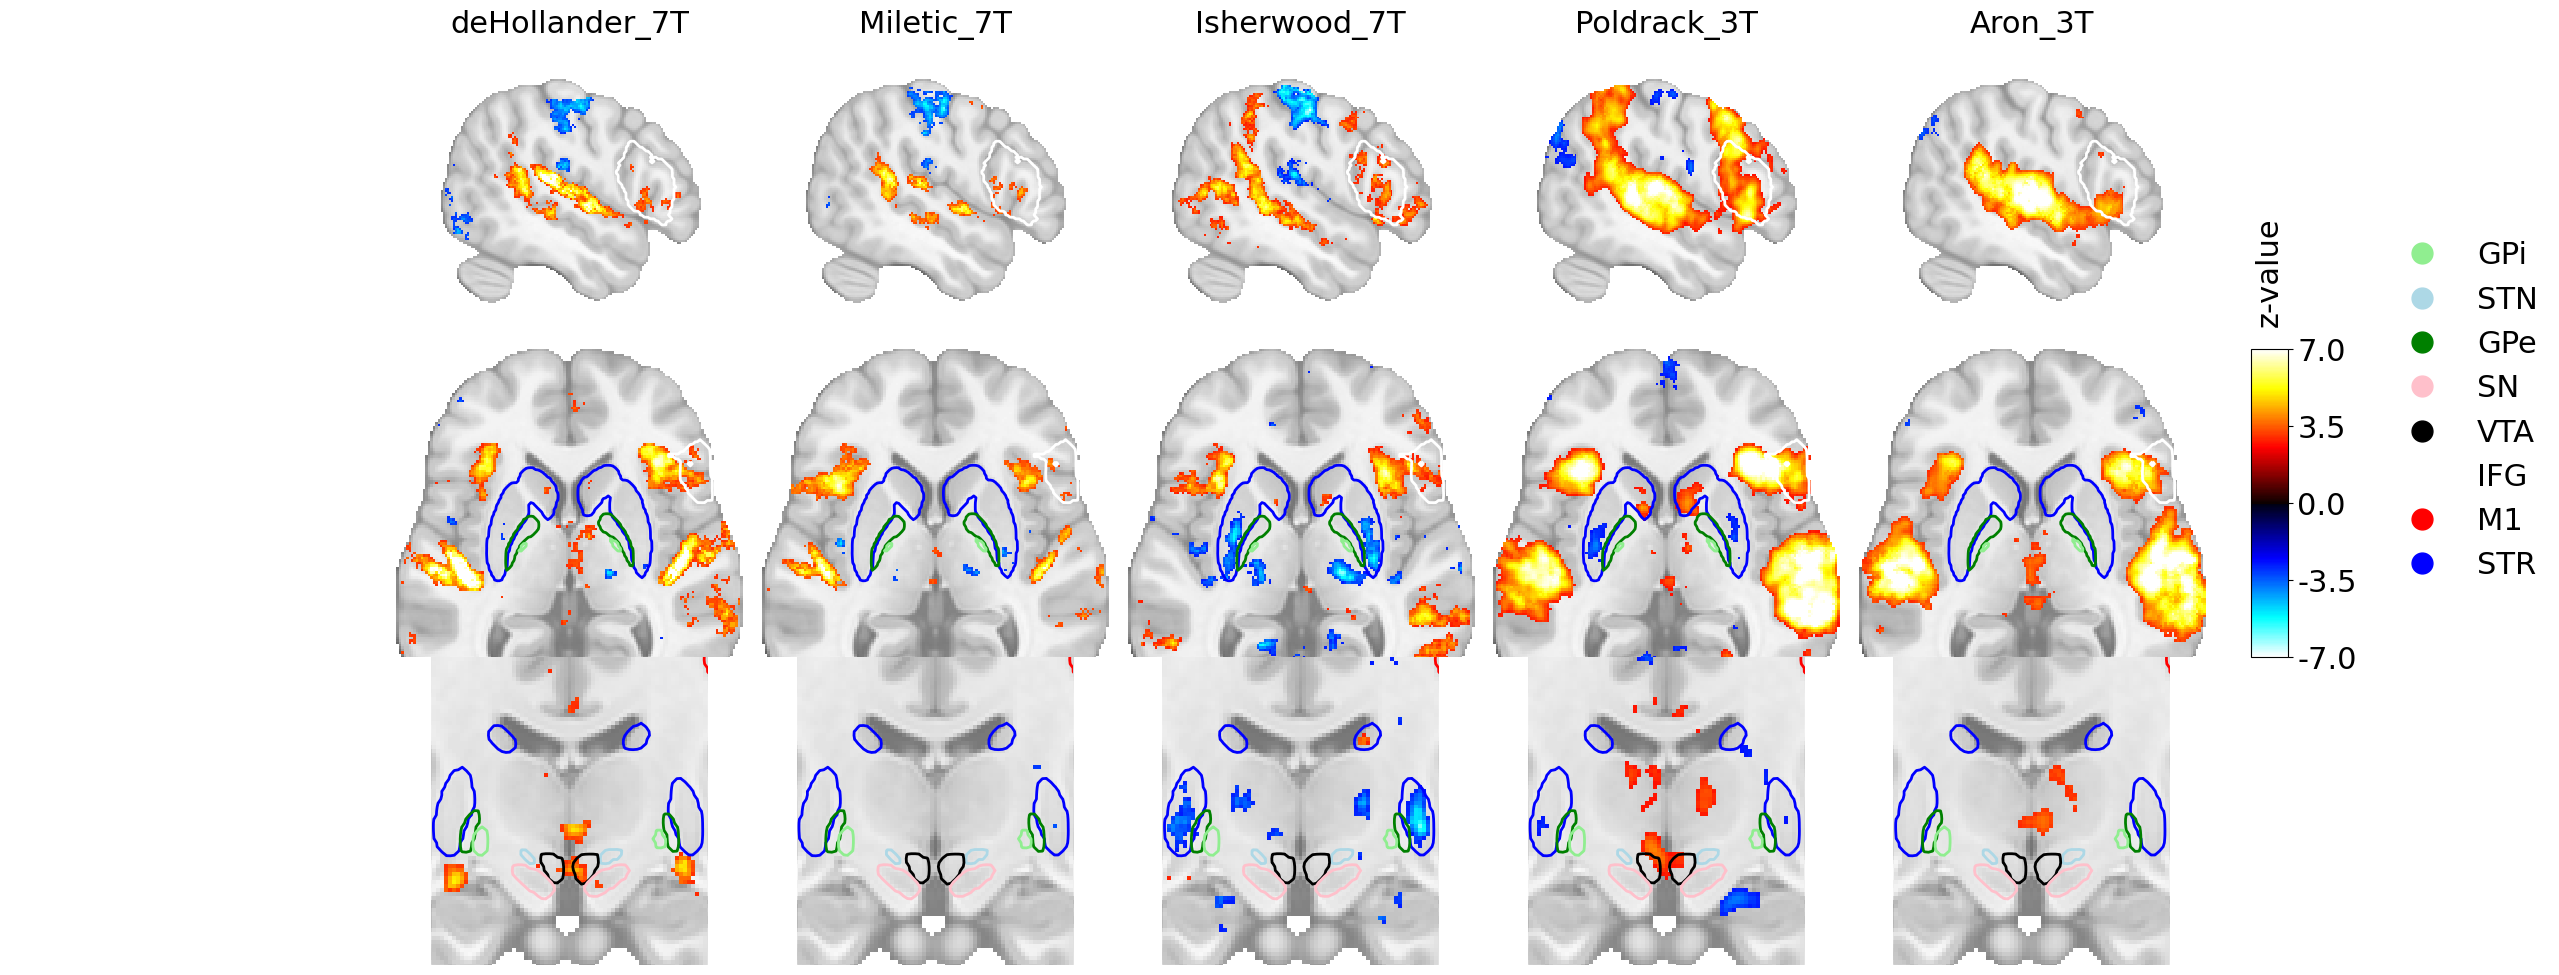

In [21]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_ssgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_ssgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_ssgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_ssgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_ssgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FWHM -> 3p125

## FS - GO

Text(0.5, 1.0, 'z-value')

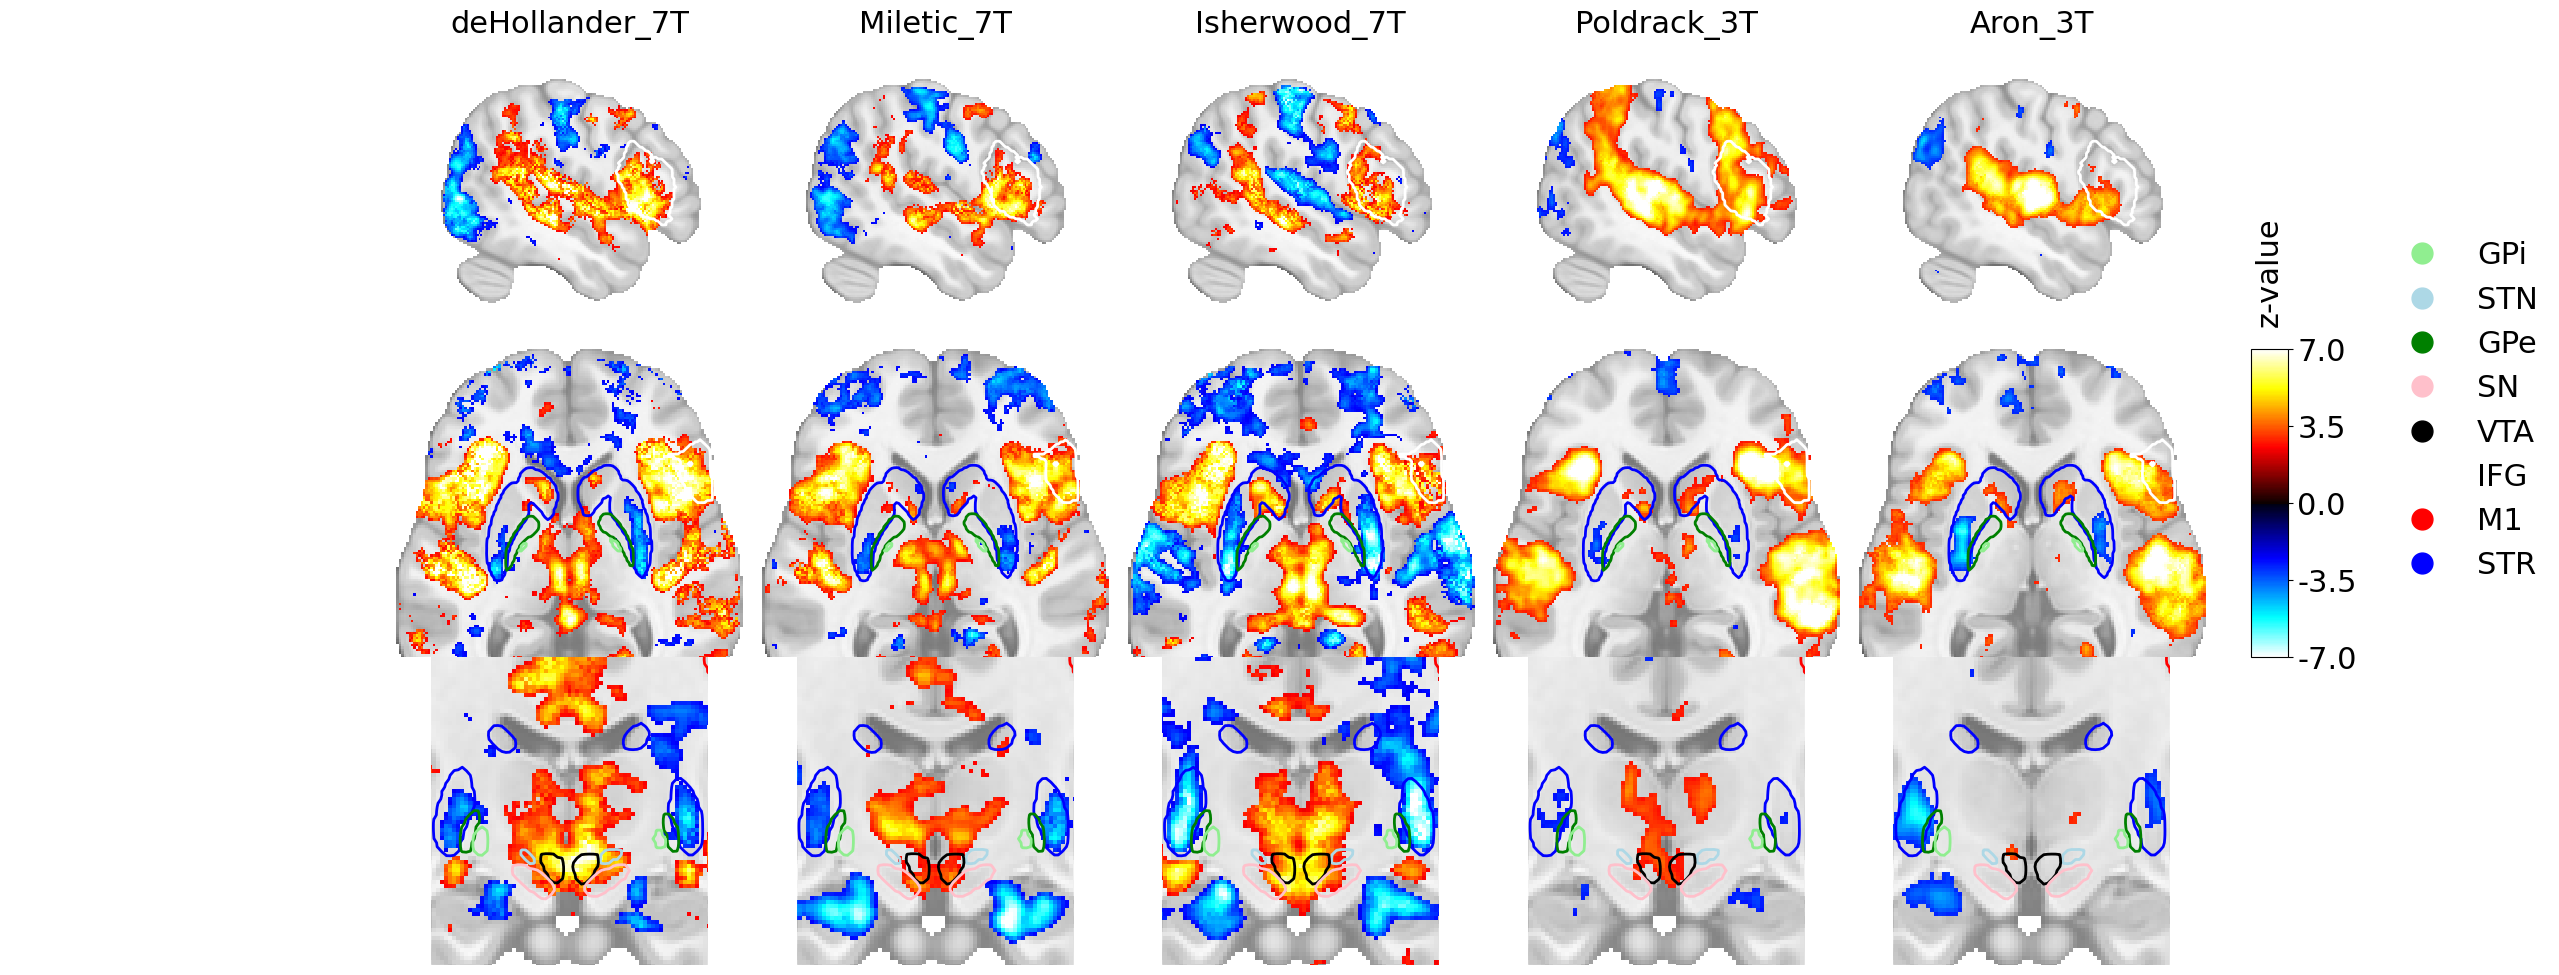

In [26]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FS - SS

Text(0.5, 1.0, 'z-value')

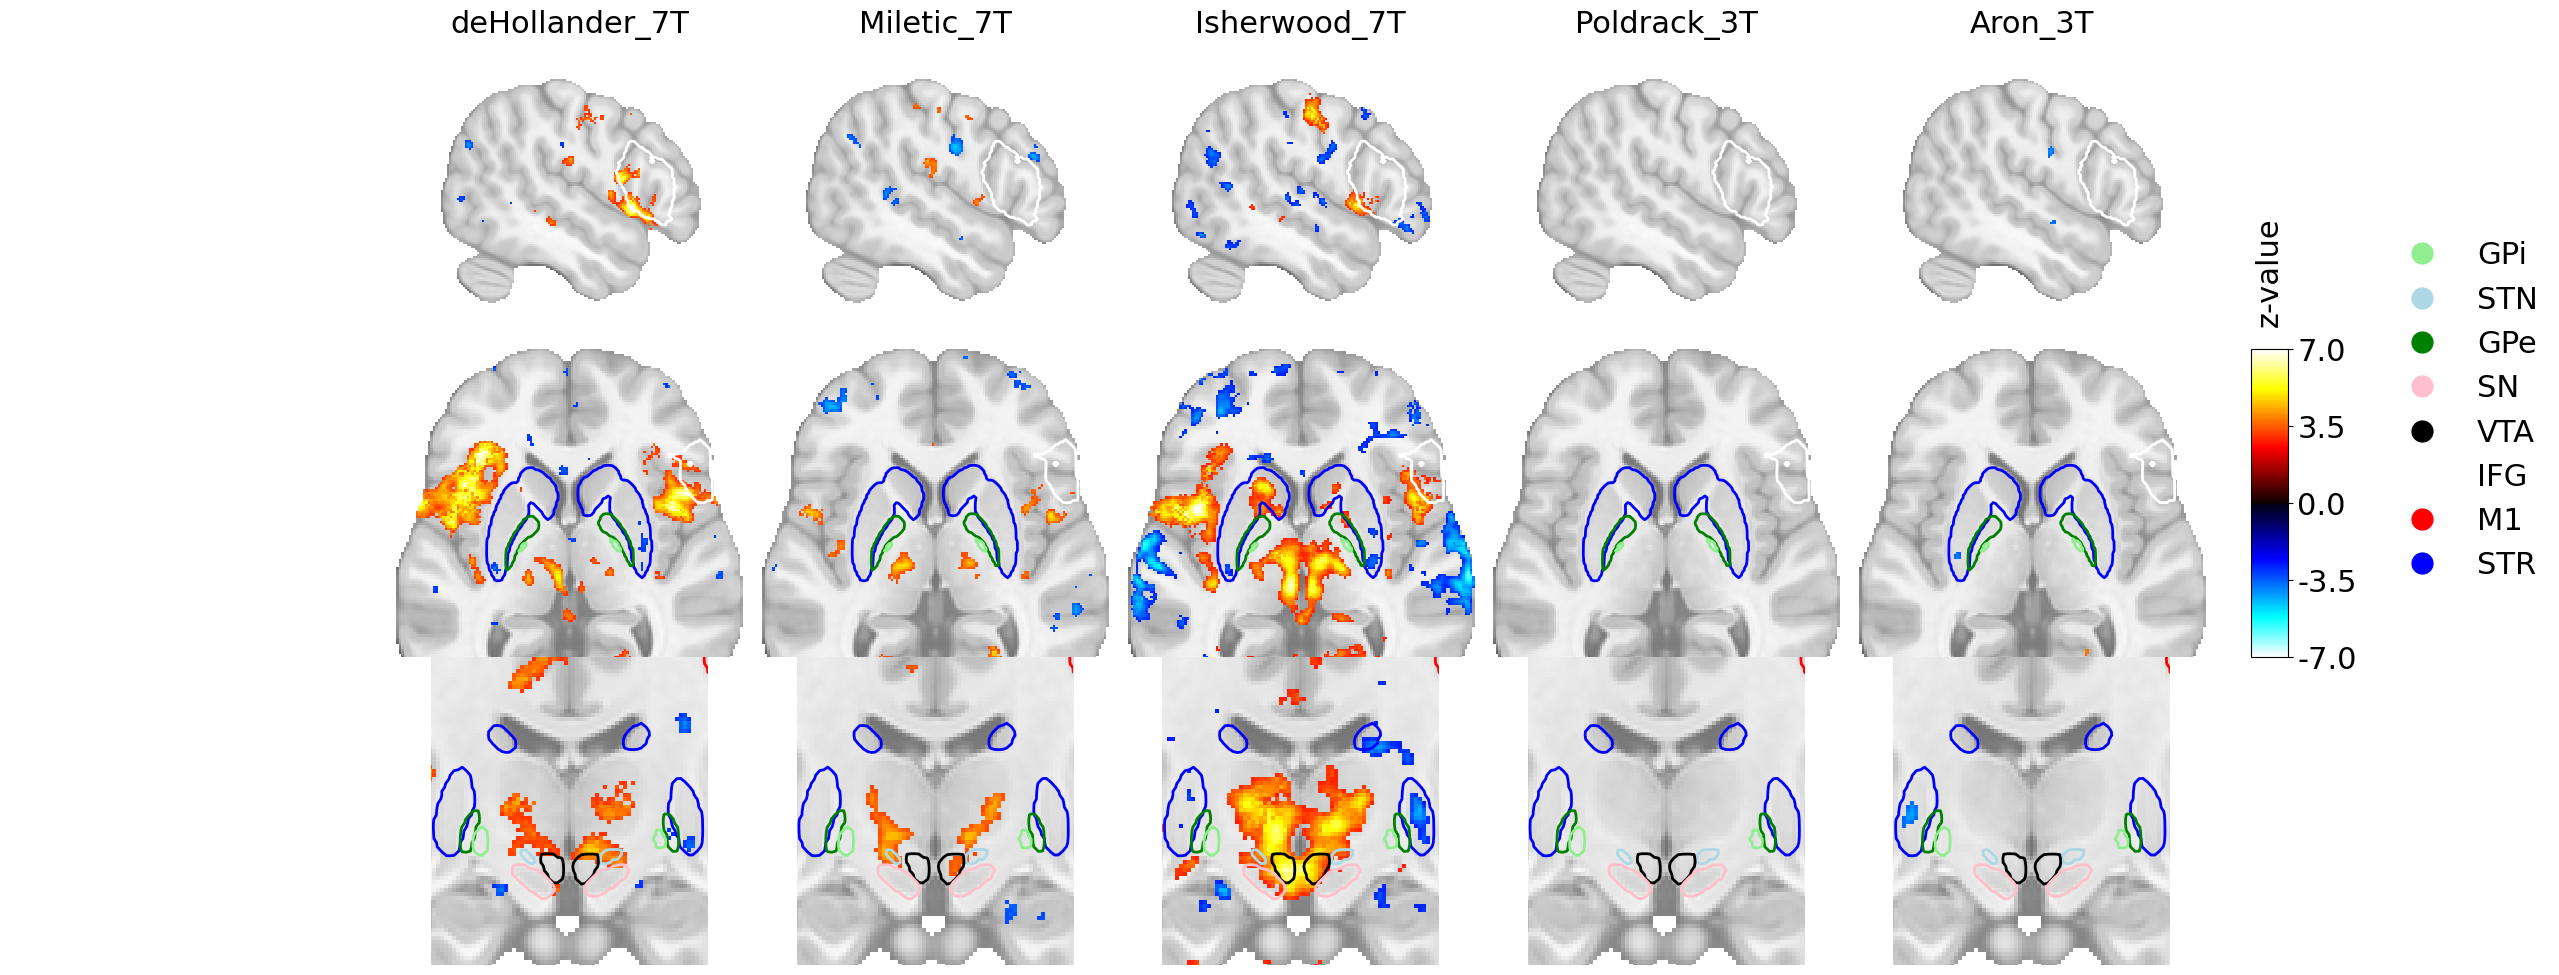

In [27]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsss) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsss)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsss)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsss, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsss,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## SS - GO

Text(0.5, 1.0, 'z-value')

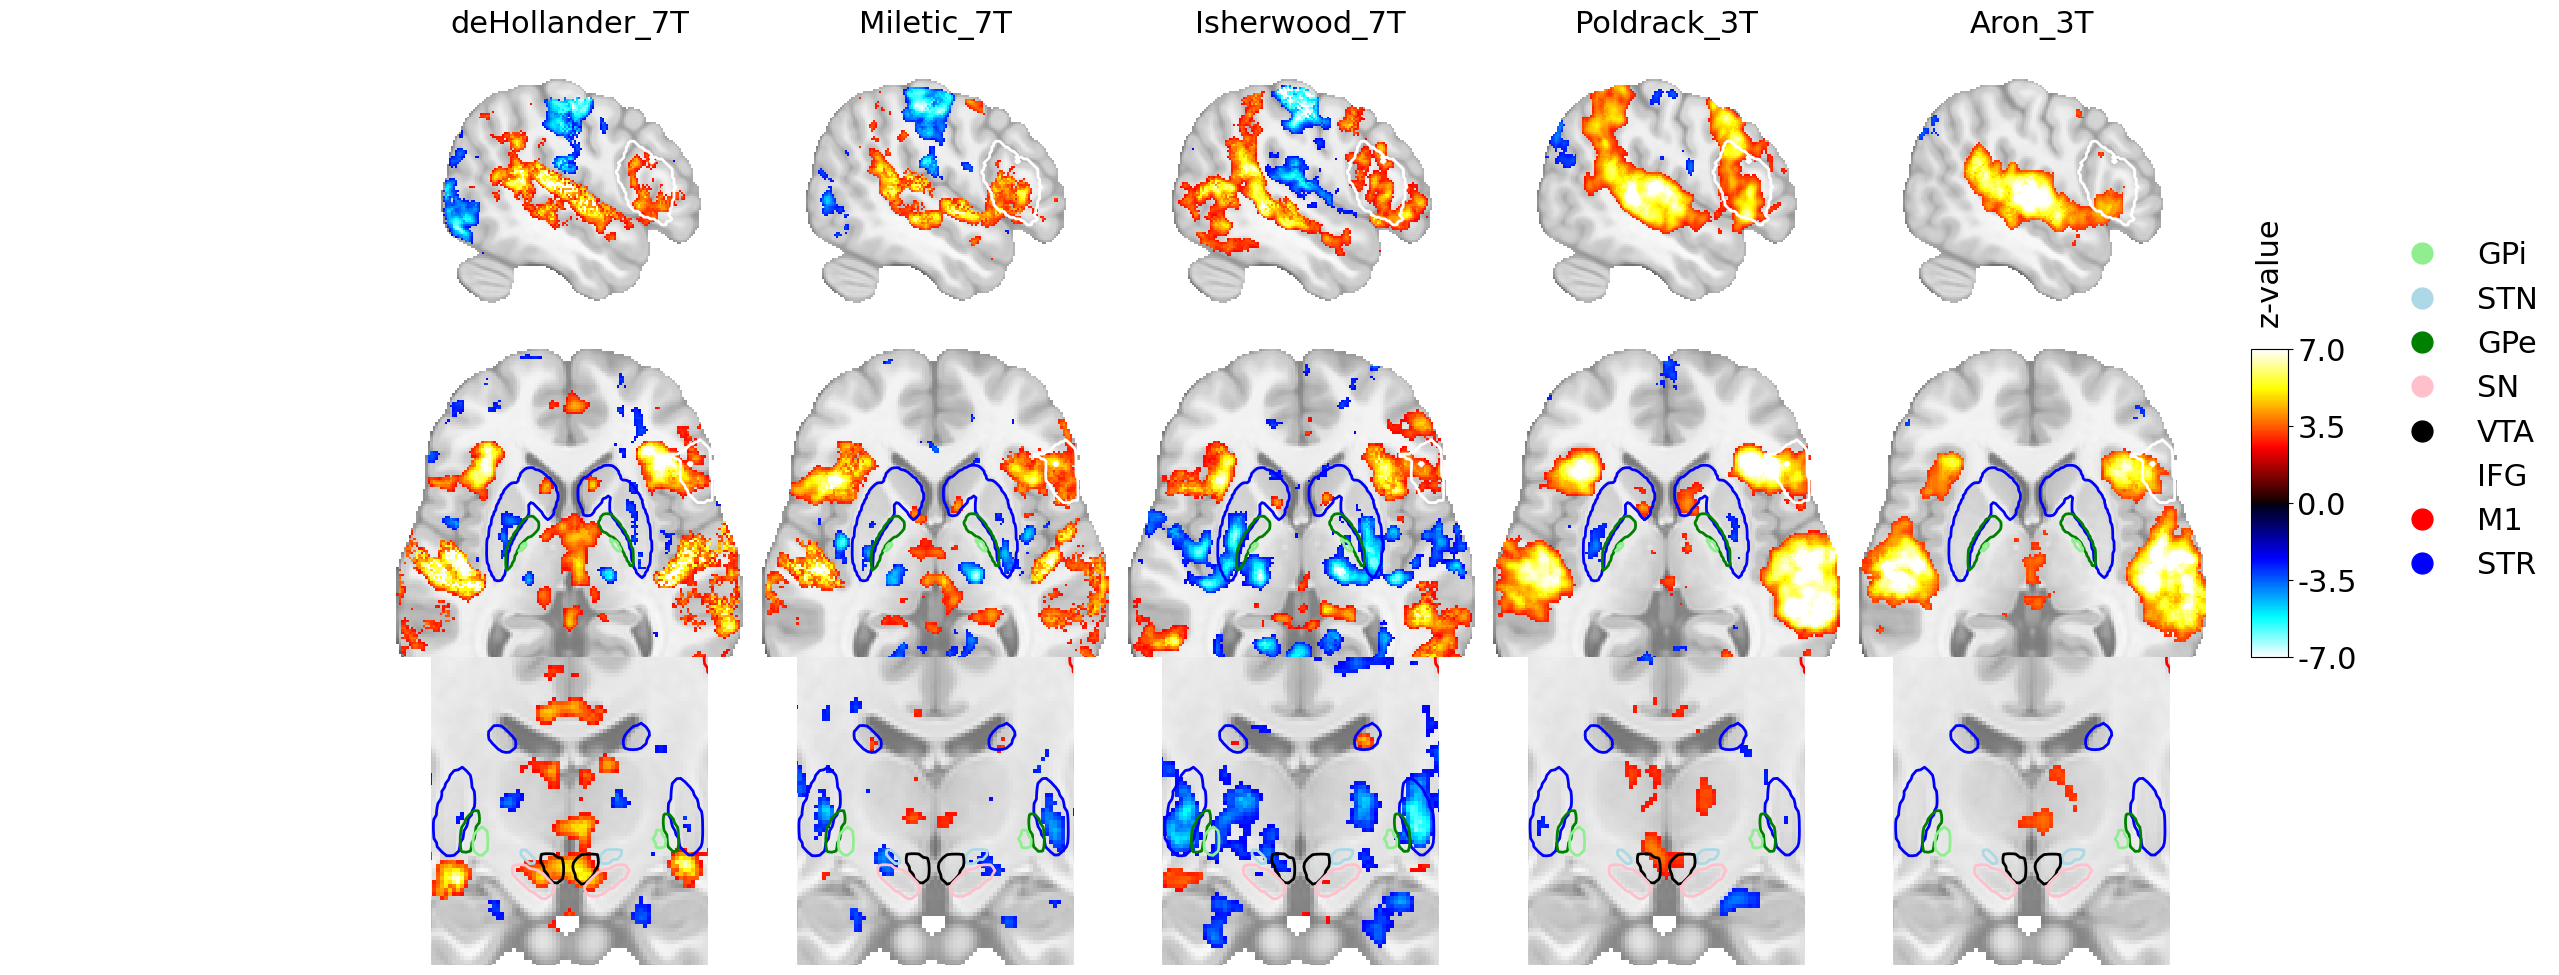

In [28]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_ssgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_ssgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_ssgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_ssgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_ssgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FWHM -> 5p0

## FS - GO

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


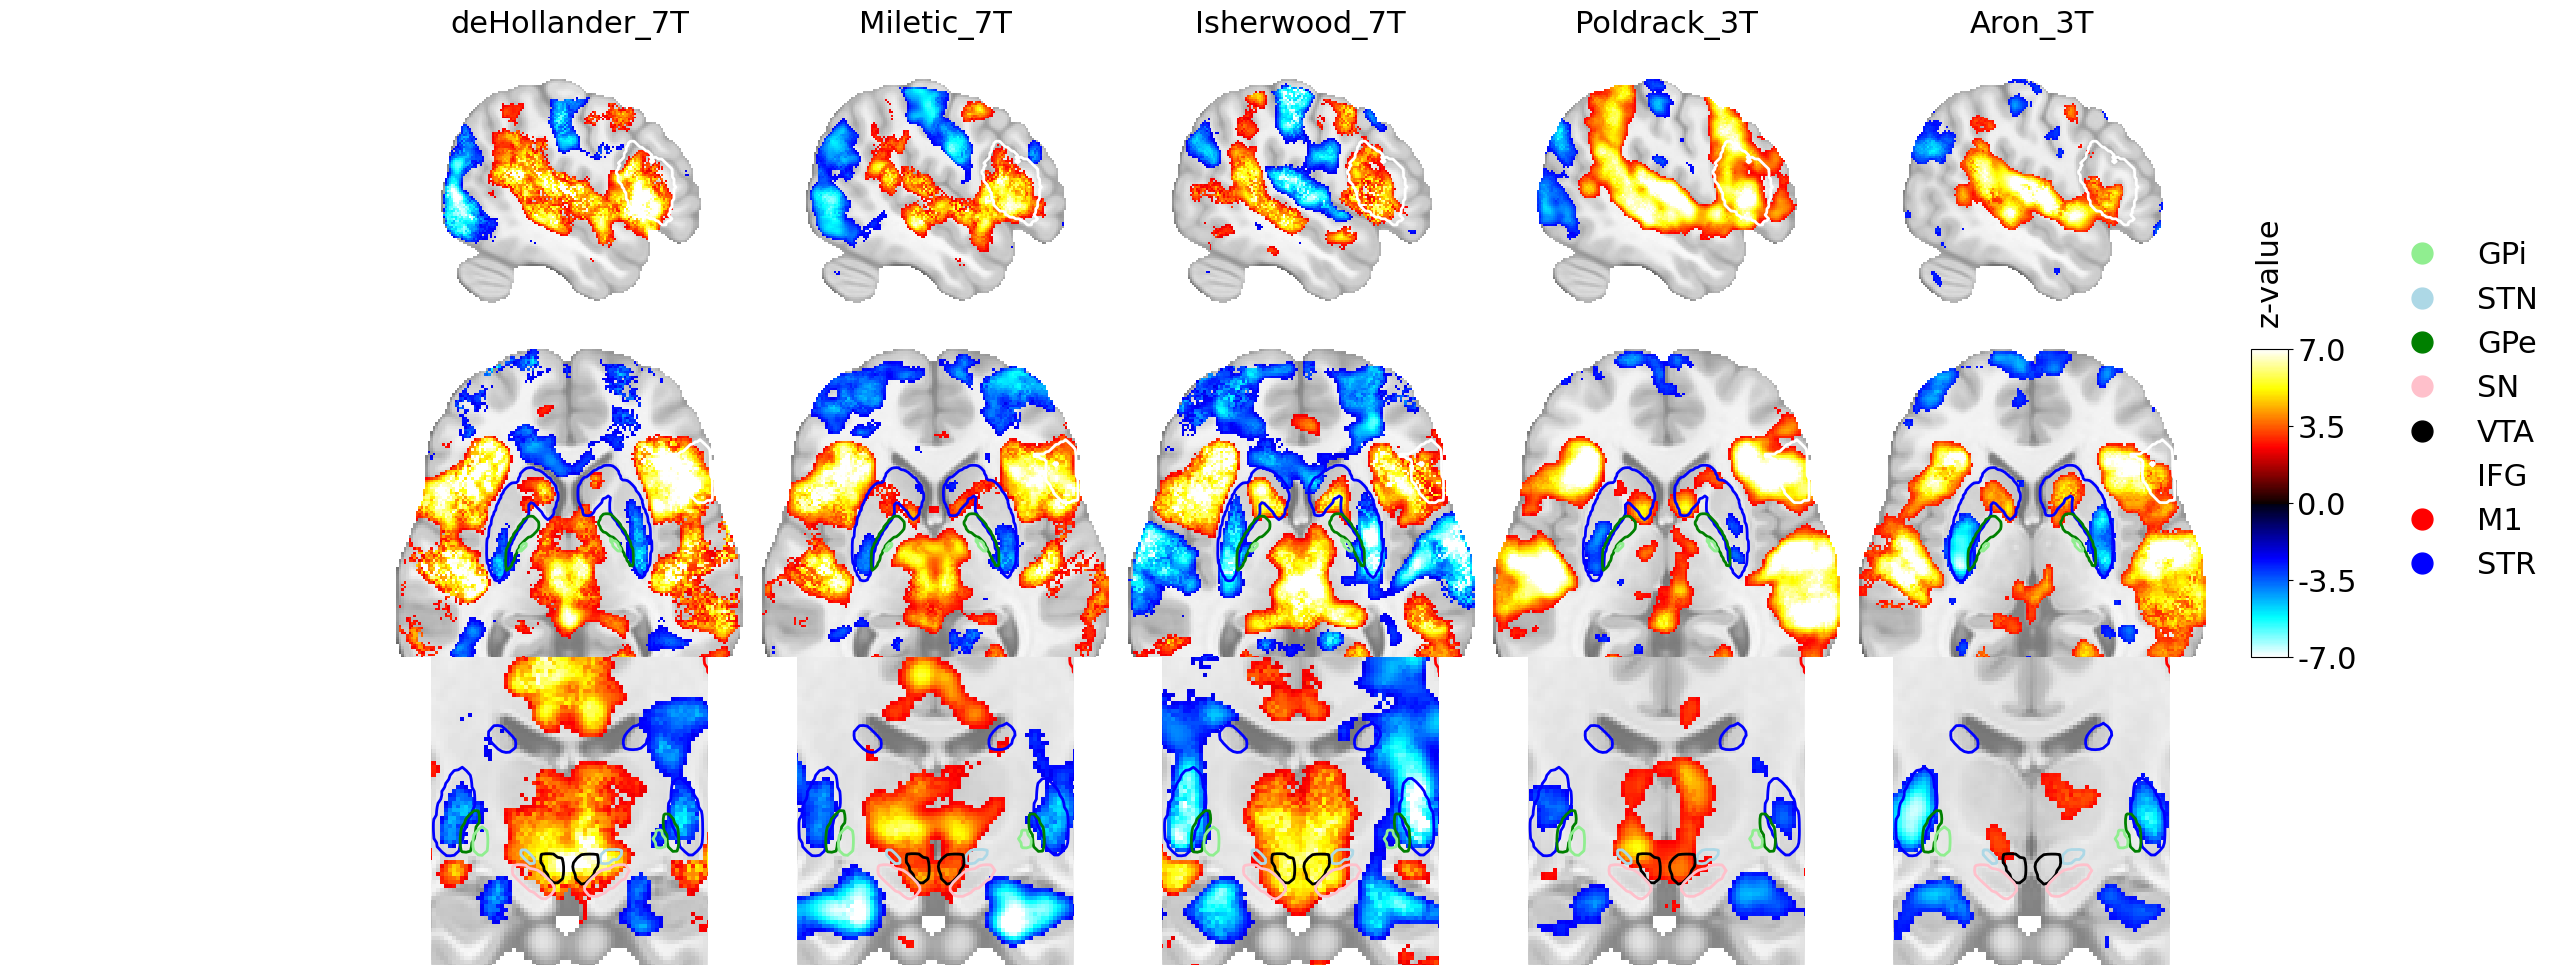

In [9]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FS - SS

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

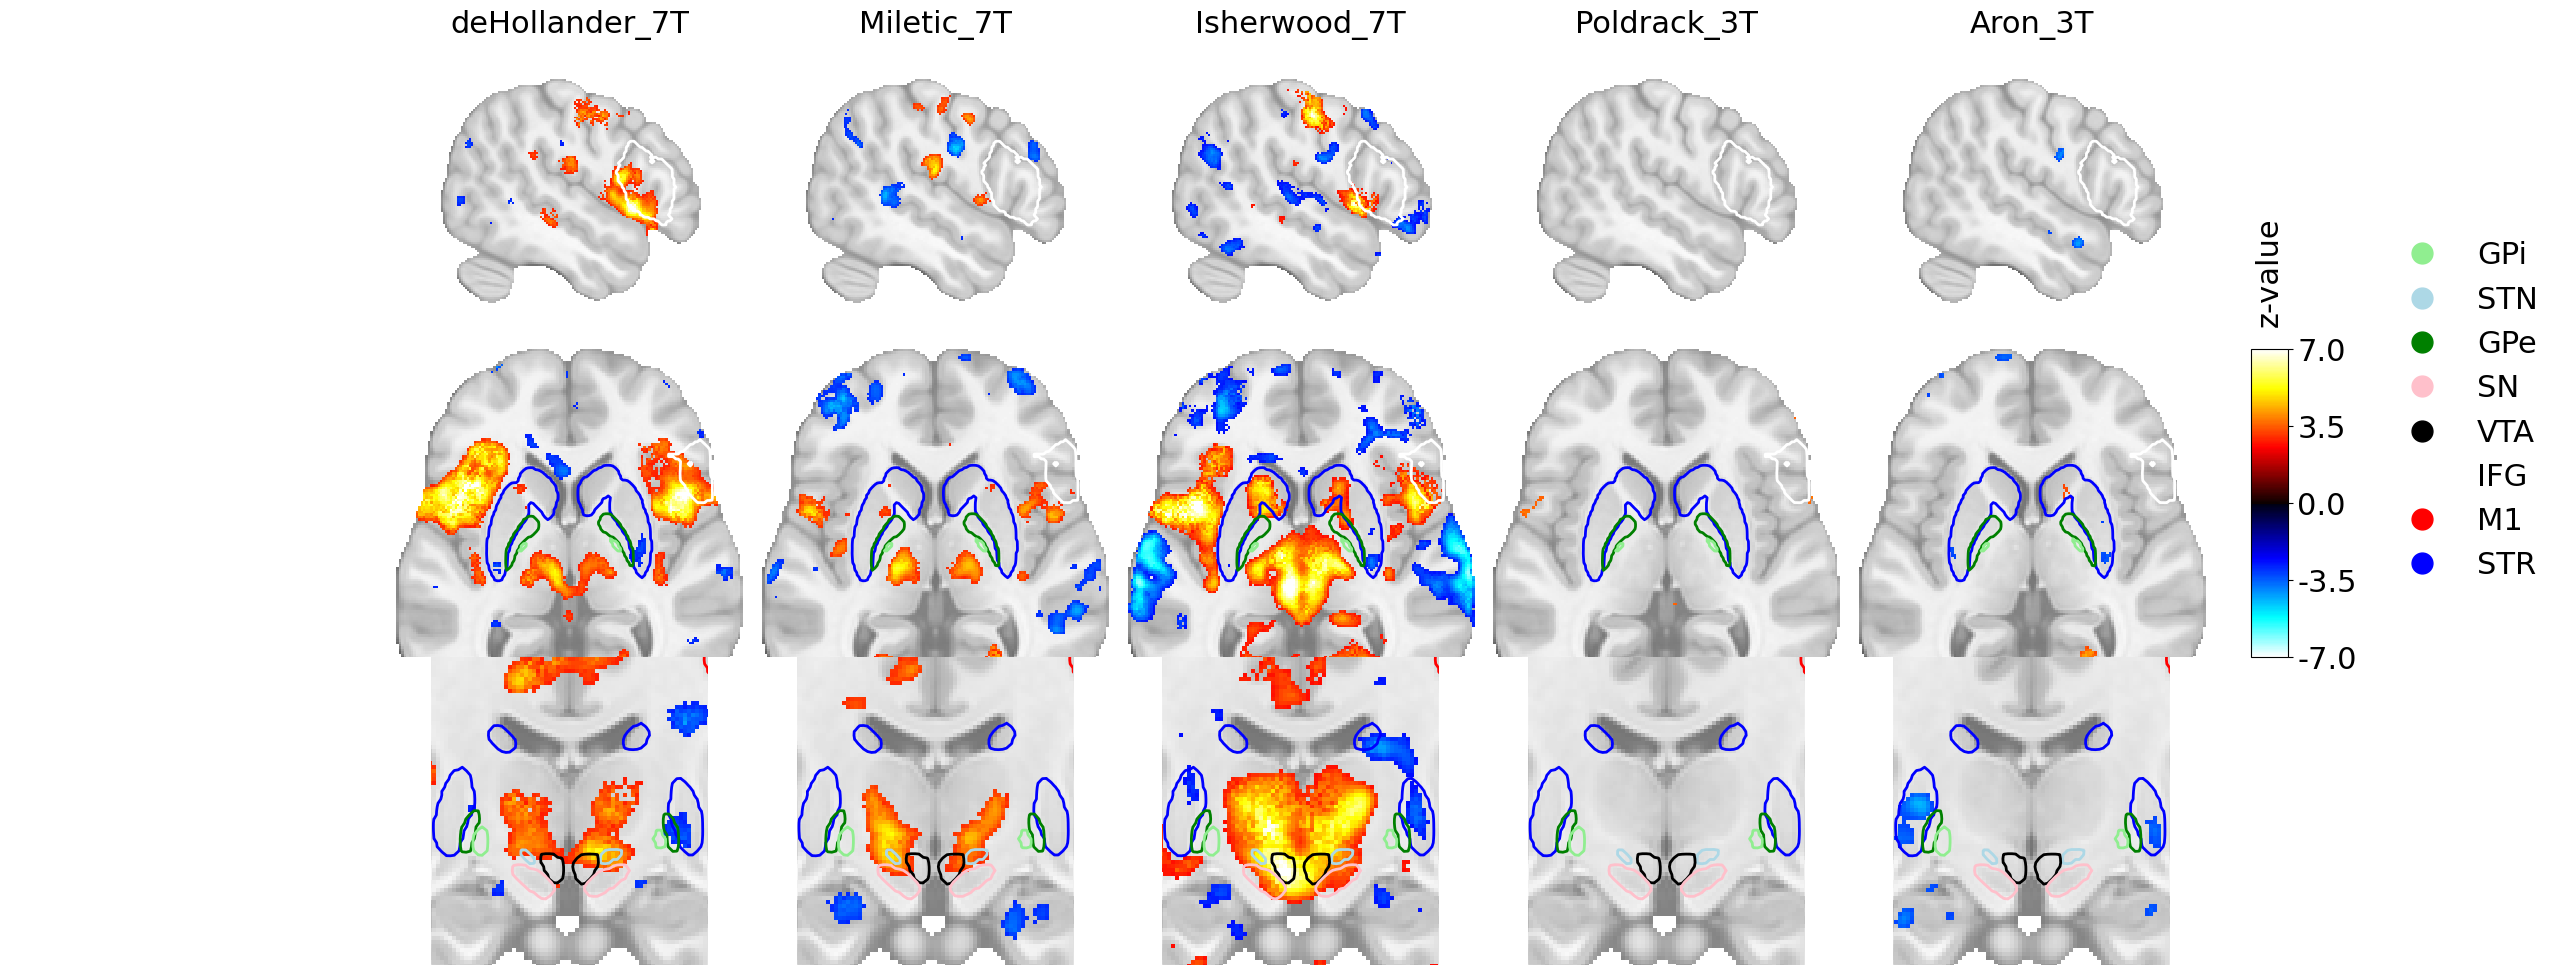

In [15]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsss) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsss)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsss)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsss, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_fsss,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## SS - GO

Text(0.5, 1.0, 'z-value')

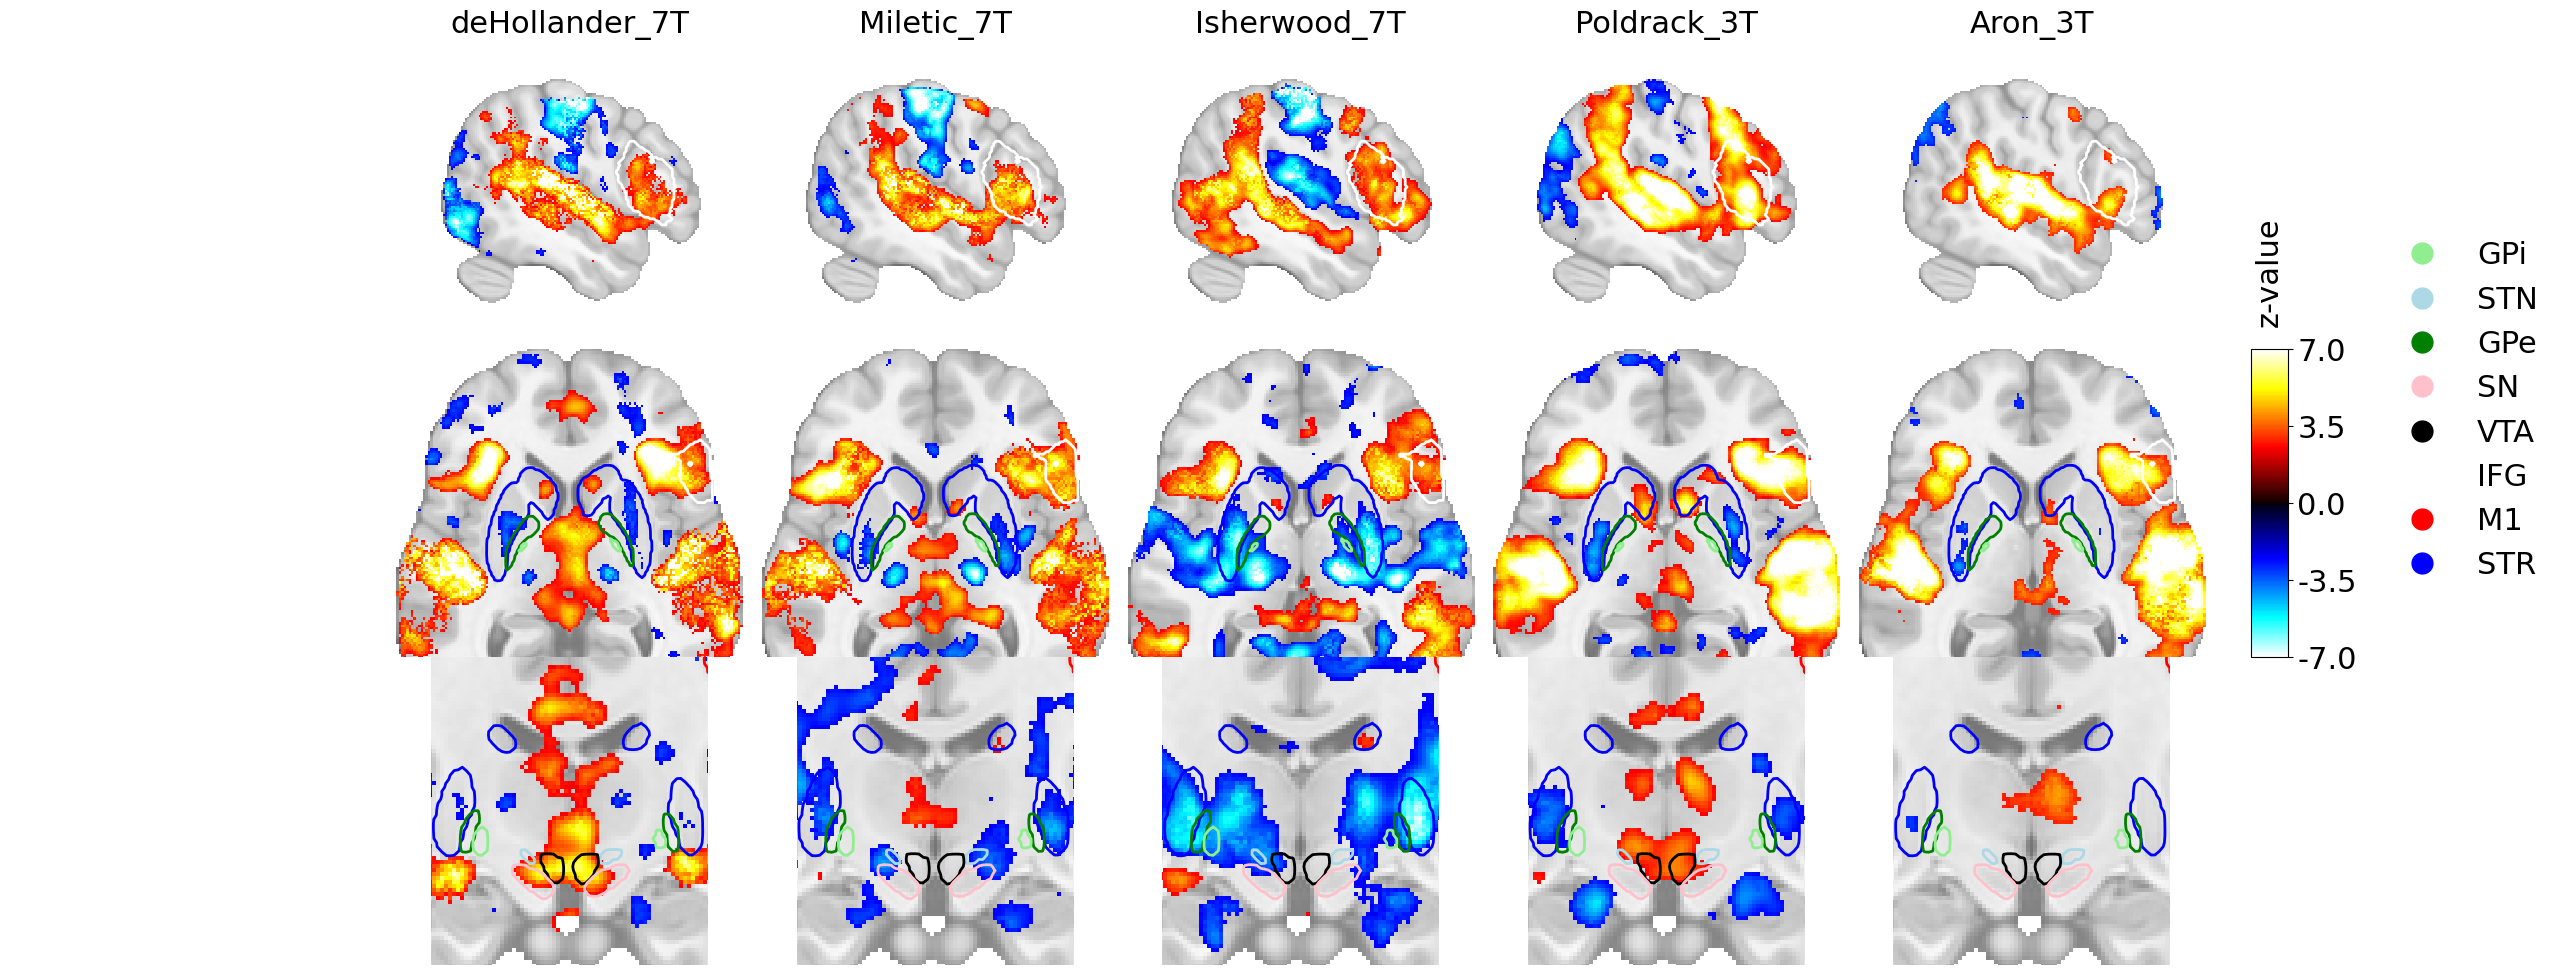

In [16]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_ssgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_ssgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_ssgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_ssgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh_ssgo,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('deHollander_7T')
axes[0,1].set_title('Miletic_7T')
axes[0,2].set_title('Isherwood_7T')
axes[0,3].set_title('Poldrack_3T')
axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')